In [1]:
using StatsBase
using Distributions


# Input parameters

const BURN_IN_GEN_N = 800
const TOTAL_GEN_N = 1100

# Max coordinates of the population bounding space
const X_MAX_BURN_IN = 5
const X_MAX = 500

const X_START = X_MAX_BURN_IN

# Dimensions of the whole space
const X_DIM = X_MAX

# Population parameters
#const INIT_PERSON_N = 30
const DEMES_FULL_AT_START = 5
const K_CAPACITY = 100
const R_PROLIF_RATE = 2
const r_LOG_PROLIF_RATE = log(2)

# Gene parameters
const LOCI_N = 20
const MUT_RATE = 0.05
const M_MIG_RATE = 0.05
const MUT_DELETER_RATE = 0.45
const S_SELECT_COEF = 0.005

x_range = 1:Int(X_START)
init_coords = sample(x_range,DEMES_FULL_AT_START;replace=false)

world = Array{Array{Array{Float32}}}(undef,X_DIM)

for coord in init_coords
    if !isassigned(world,coord)
        world[coord] = []
    end
    for i in 1:K_CAPACITY
        push!(world[coord],ones(LOCI_N*2))
    end
end

@inbounds function multi_fitn_in_person(person)
    return prod(person)
end

@inbounds function max_fitn(persons_at_pos)
    return maximum(multi_fitn_in_person.(persons_at_pos))
end

@inbounds function mean_fitn(persons_at_pos)
    return mean(multi_fitn_in_person.(persons_at_pos))
end

@inbounds function mutate(person)
    get_mutation_random = rand(Poisson(MUT_RATE))
    @fastmath @inbounds for _ in 1:get_mutation_random
        pos_alter = sample(1:LOCI_N)
        if rand() < MUT_DELETER_RATE
            person[pos_alter] *= 1 - S_SELECT_COEF
        else
            person[pos_alter] *= 1 + S_SELECT_COEF
        end
    end
end

@inbounds function recombine(person)
    for i in 1:LOCI_N
        lr = rand(1:2)
        person[i] = lr==1 ? person[i] : person[i+LOCI_N]
    end
end

@inbounds function mate_cond(mom_fit,dad_fit,max_fitness)
    return (mom_fit > rand()*max_fitness) & (dad_fit > rand()*max_fitness)
end

@inbounds function mate(person1,person2)
    new_loci = vcat(person1[1:LOCI_N],person2[1:LOCI_N])
    return new_loci
end

@inbounds @inbounds function build_next_gen(wld,x_max_migrate)
    # Function 1
    next_gen_pops = zeros(Int16,X_DIM)
    next_gen_posits = []
    fill!(next_gen_pops,-1)
    for x in 1:X_DIM
        if isassigned(world,x) && length(world[x])>0
            n_ppl_at_deme = length(world[x])
            expected_offspring = n_ppl_at_deme * (R_PROLIF_RATE/(1 + (n_ppl_at_deme*(R_PROLIF_RATE-1))/K_CAPACITY))
            next_gen_pops[x] =  rand(Poisson(expected_offspring))
            if next_gen_pops[x]>0
                push!(next_gen_posits,x)
            end
        end
    end
    

    # Function 2
    #wld_next = Array{Person}(undef,sum(next_gen_pops))
    wld_next = Array{Array{Array{Float32}}}(undef,X_DIM)
    
    all_birth_count = 0

    # Function 3
    mean_fitn_wld = Array{Float32}(undef,X_DIM)
    fill!(mean_fitn_wld,-1)
    pops_wld = zeros(Int32,X_DIM)

    for deme in next_gen_posits
        curr_persons_at_pos = wld[deme]
        mean_fitn_wld[deme] = mean_fitn(curr_persons_at_pos)
        max_fitness =  max_fitn(curr_persons_at_pos)

        next_generation_size = next_gen_pops[deme]
        
        if next_generation_size > 0
            birth_count = 0
            while birth_count < next_generation_size
                mom = curr_persons_at_pos[rand(1:end)]
                dad = curr_persons_at_pos[rand(1:end)]
                mom_fit = multi_fitn_in_person(mom)
                dad_fit = multi_fitn_in_person(dad)




                #print(mate_cond(relative_extract_xx_ind,relative_extract_xy_ind,max_fitness))
                if mate_cond(mom_fit,dad_fit,max_fitness)
                    #println(mom)
                    gamete_mom = copy(mom) # technically a person, but we'll only use the first half of loci
                    gamete_dad = copy(dad) # technically a person, but we'll only use the first half of loci
                    recombine(gamete_mom)
                    recombine(gamete_dad)
                    mutate(gamete_mom)
                    mutate(gamete_dad)
                    mate_result = mate(gamete_mom,gamete_dad)

                    wv = [M_MIG_RATE/2,1-M_MIG_RATE,M_MIG_RATE/2]
                    move_x = sample(-1:1,Weights(wv))
                    if deme[1]+move_x > x_max_migrate || deme[1]+move_x < 1
                        #move_x = 0
                        move_x = -move_x
                    end
                    if !isassigned(wld_next,deme[1]+move_x)
                        wld_next[deme[1]+move_x] = []
                    end
                    push!(wld_next[deme[1]+move_x],mate_result)

                    birth_count += 1
                    all_birth_count += 1
                end
            end
            pops_wld[deme] = birth_count
        end
    end
    return wld_next,mean_fitn_wld,pops_wld
end

meanf_world = Array{Float32}(undef,X_DIM,0)
pops_world = Array{Float32}(undef,X_DIM,0)

@inbounds for _ in 1:BURN_IN_GEN_N
    global world,meanf,pops = build_next_gen(world,X_MAX_BURN_IN)
    global meanf_world = cat(meanf_world,meanf, dims=2)
    global pops_world = cat(pops_world,pops, dims=2)
end

@inbounds for _ in (BURN_IN_GEN_N+1):TOTAL_GEN_N
    global world,meanf,pops = build_next_gen(world,X_MAX)
    global meanf_world = cat(meanf_world,meanf, dims=2)
    global pops_world = cat(pops_world,pops, dims=2)
end

defined_world = []
for i in 1:X_DIM
    if isassigned(world,i)
        push!(defined_world, world[i])
    end
end
println(sum(length.(defined_world)))

8379


In [2]:
#= using Plots

slow_down = 5
gen_start = 0
gen_end = 10

@gif for i=gen_start:(gen_end*slow_down-1)
    gen_no = trunc(Int,i/slow_down)+1
    heatmap(reshape(pops_world[:,gen_no],1,length(pops_world[:,gen_no])),yticks=false,aspect_ratio=1,clims=(K_CAPACITY-50,K_CAPACITY+5),xlabel="gen=$(gen_no-1)",xlims=(0,20),ylims=(0,8))
end =#

In [3]:
#= slow_down = 1
gen_start = 1090
gen_end = 1100

@gif for i=gen_start:(gen_end*slow_down-1)
    gen_no = trunc(Int,i/slow_down)+1
    heatmap(reshape(pops_world[:,gen_no],1,length(pops_world[:,gen_no])),yticks=false,aspect_ratio=1,clims=(K_CAPACITY-50,K_CAPACITY+5),xlabel="gen=$(gen_no-1)",xlims=(50,100),ylims=(0,8))
end =#

In [4]:
function N_t(m,r,K,t)
    x_ = (m/2)*K*exp(r*t)
    if x_ >= K
        x_ =  K
    end
    return x_
end

function growth_T(m,r)
    return log(2/m)/r
end

function s_e(s,m,r)
    return s*(m/2)*growth_T(m,r)
end

function x0(s,m,r,K,t)
    x_ = exp(s*(growth_T(m,r)-t))
    x_ /= (exp(s*(growth_T(m,r)-t))+2*N_t(m,r,K,t)-1)
    return x_
end

function u_p_cubic(P,s,m,r,K)
    local myexp = exp(s*growth_T(m,r))
    
    return (3*myexp*(myexp-1)*P-K*m*((myexp-1)*P+1)^3+K*m)/(3*myexp*(myexp-1)-K*m*myexp^3+K*m)
end

h2(s,m,r,K) = sqrt(exp(-s*growth_T(m,r))*K*m) # A* in my PDF
h1(s,m,r) = expm1(s*growth_T(m,r)) # B in my PDF

function u_p(P,s,m,r,K)
    local myh1 = h1(s,m,r)
    local myh2 = h2(s,m,r,K)
    u_ = erf(myh1*myh2*P+myh2)-erf(myh2)
    u_ /= erf(myh1*myh2+myh2)-erf(myh2)
    return u_
end

function u_p_peischl(P,s,m,r,K)
    local mys_e = s_e(s,m,r)
    u_ = expm1(-4*mys_e*K_CAPACITY*P)
    u_ /= expm1(-4*mys_e*K_CAPACITY)
    return u_
end

#= function u_p_alt(P,s,m,r,K)
    myA = s*growth_T(m,r)
    myB = 2/K/m
    u_1 = (-1+0im)^myB * _₂F₁(1,myB,2+myB,1-exp(myA))
    u_ = u_1 / ((P-1+0im)^(1+myB) * exp(-myB*myA) * _₂F₁(myB,1+myB,2+myB,(exp(-myA)-1)*(P-1)) + u_1)
    return u_
end =#
function u_p_alt(P,s,m,r,K)
    myA = expm1(s*growth_T(m,r))
    myB = 2/K/m + 1
    u_ = ((myA*P+1)^myB - 1)/((myA+1)^myB - 1)
    return u_
end

u_p_alt (generic function with 1 method)

In [5]:
LOCI_N_THEORY = LOCI_N

function large_p(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function large_p_test(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p_peischl(x0(s,m,r,K,t),s,m,r,K)
    return P_
end
function large_p_test2(s,m,r,K,t,u,n,phi)
    P_ = 2*N_t(m,K,r,t)*(u/n)*phi*u_p(x0(s,m,r,K,t),1,m,r,K)
    return P_
end
function mu_effect(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end
function mu_effect_test2(t)
    mu_ = (2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,1-MUT_DELETER_RATE)
    mu_ += (-2*S_SELECT_COEF+S_SELECT_COEF^2)*large_p_test2(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,t,MUT_RATE,LOCI_N_THEORY,MUT_DELETER_RATE)
    return mu_
end

function large_p_2015(s,migr,r,K,mut)
    my_4seK = 4*s_e(s,migr,r)*K
    P_ = -mut*my_4seK/expm1(-my_4seK)
    return P_
end
function mu_effect_2015(t)
    mu_ = 2*S_SELECT_COEF*(1-MUT_DELETER_RATE)*large_p_2015(S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    mu_ -= 2*S_SELECT_COEF*MUT_DELETER_RATE*large_p_2015(-S_SELECT_COEF,M_MIG_RATE,r_LOG_PROLIF_RATE,K_CAPACITY,MUT_RATE)
    return mu_
end

mu_effect_2015 (generic function with 1 method)

In [6]:
using QuadGK

function find_mf_theory(start_mf;mu_func=mu_effect)
    my_T = growth_T(M_MIG_RATE,r_LOG_PROLIF_RATE)
    sim_inte_result = quadgk(mu_func,0,my_T)[1]/my_T

    mean_fitness_sim_result = Array{Float64}(undef,0)

    for t_i in 1:BURN_IN_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,0,dims=1)
    end

    mean_fitness_sim_result = cat(mean_fitness_sim_result,start_mf, dims=1)

    for t_i in (BURN_IN_GEN_N+2):TOTAL_GEN_N
        mean_fitness_sim_result = cat(mean_fitness_sim_result,mean_fitness_sim_result[t_i-1]*(1+sim_inte_result)^LOCI_N_THEORY, dims=1)
    end
    return mean_fitness_sim_result
end

find_mf_theory (generic function with 1 method)

In [7]:
function get_normalised_matrix_max(meanfit_array)
    normal_array = copy(meanfit_array)
    for j in 1:(TOTAL_GEN_N-BURN_IN_GEN_N)
        gen_max = maximum(meanfit_array[:,BURN_IN_GEN_N+j])
        normal_array[:,BURN_IN_GEN_N+j] /= gen_max
    end
    return normal_array
end

function get_normalised_matrix_onset_mean(meanfit_array)
    normal_array = copy(meanfit_array)
    
    sum = 0
    count = 0
    for u in meanfit_array[:,BURN_IN_GEN_N+1]
        if u > 0
            sum += u
            count += 1
        end
    end
    gen_max = sum/count

    normal_array[:,BURN_IN_GEN_N+1:end] /= gen_max
    return normal_array
end

function find_front(meanfit_array,gen_n=TOTAL_GEN_N)
    front_array = Array{Float32}(undef,0)
    for j in 1:gen_n
        frontier = X_MAX
        while frontier != 1 && meanfit_array[frontier,j] < 0
            frontier -= 1
        end
        sum_total = meanfit_array[frontier,j]
        front_array = cat(front_array,sum_total, dims=1)
    end
    return front_array
end

find_front (generic function with 2 methods)

In [8]:
meanf_normal = get_normalised_matrix_onset_mean(meanf_world)
meanf_front_normal = find_front(meanf_normal)
meanf_front = find_front(meanf_world)

1100-element Vector{Float32}:
 1.0
 0.9997594
 0.99967617
 0.99982584
 0.9993268
 0.99965525
 0.9994845
 0.9994992
 0.9992704
 0.9989878
 ⋮
 1.844939
 1.8424544
 1.8277864
 1.8247327
 1.8291088
 1.8247174
 1.823614
 1.8094867
 1.8186135

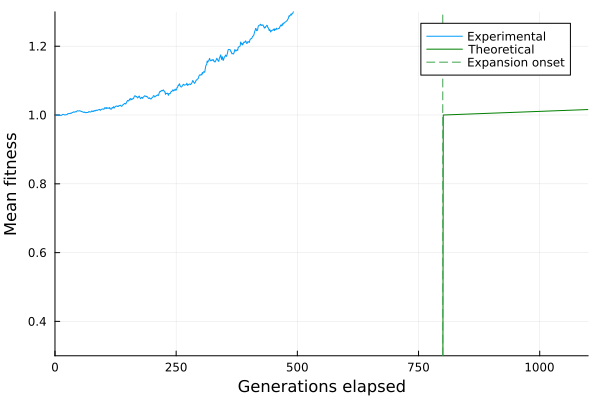

In [9]:
using Plots
plot(meanf_front,label = "Experimental",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Mean fitness",yrange=(0.3,1.3))
plot!(find_mf_theory(1),label = "Theoretical",color="green")
vline!([BURN_IN_GEN_N],label="Expansion onset",style=:dash)

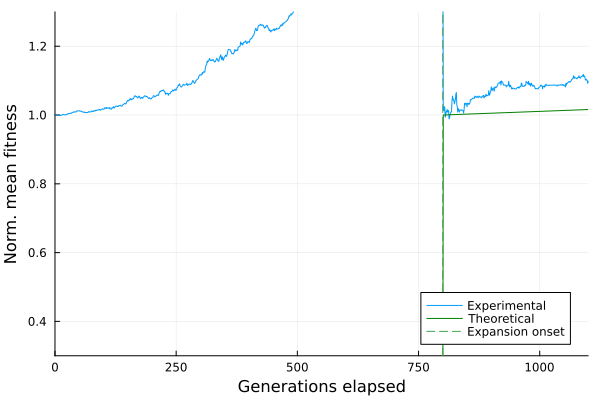

In [10]:
plot(meanf_front_normal,label = "Experimental",xlims=(0,TOTAL_GEN_N),xlabel="Generations elapsed",ylabel="Norm. mean fitness",yrange=(0.3,1.3))
plot!(find_mf_theory(1),label = "Theoretical",color="green")
vline!([BURN_IN_GEN_N],label="Expansion onset",style=:dash)